In [38]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import openai
from openai import OpenAI

# CONSTANTS
openai.organization = "org-raWgaVqCbuR9YlP1CIjclYHk" # Harvard
openai.api_key = os.getenv("OPENAI_API_KEY")
print("OPENAI API KEY OBTAINED" if openai.api_key else "MISSING API KEY")

# NB TO RUN
%run ../eda/cleaning_acled.ipynb
%run ../eda/cleaning_ucdp.ipynb

OPENAI API KEY OBTAINED


## comments on to do
- [ ] mask the dates 
- [ ] evaluate the results against the VIEWS forecasting
- [ ] bin the groups
- [ ] make algorithm autoregressive with sliding window
- [ ] enforce format with langchain (tool calling)

In [39]:
data = pd.read_csv("../data/views/Queryset_fatalities002_conflict_history_long_121-512.csv")
# data.columns
data.shape # (73552, 65)

(73552, 65)

Loading data from ../data/ucdp/somalia.csv
dimensions: (6444, 49)
dates range from 1989-01-01 to 2022-12-31


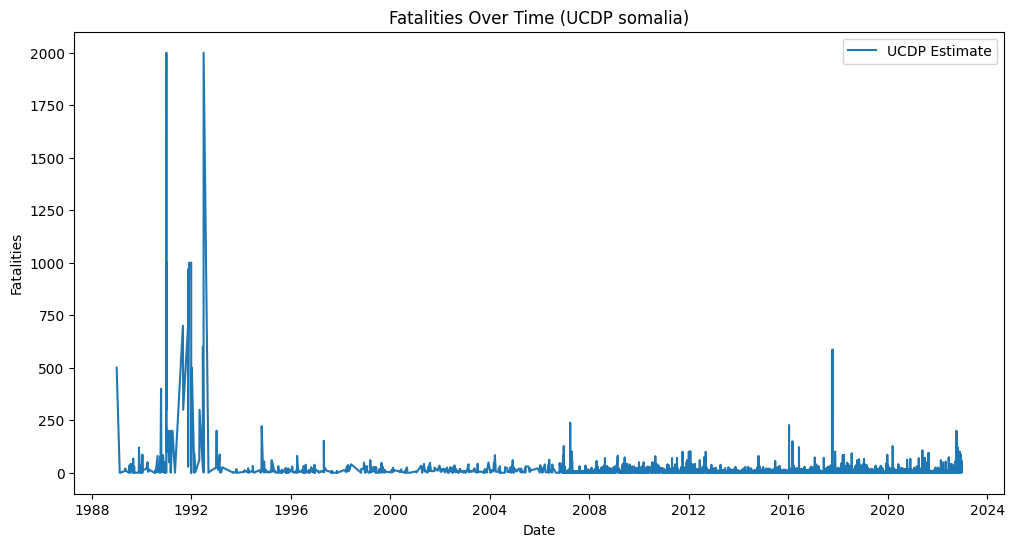

In [40]:
country = 'somalia'
ucdp_data = pd.read_csv(f"../data/ucdp/{country}.csv")

ucleaner = UCDPCleaner(country)
ucdp = ucleaner.data
print("dimensions:", ucdp.shape)
ucleaner.plot()

# VERSION ONE

In [41]:
duration = ucleaner.duration()
assert 'duration' in duration.columns


In [42]:
covariates = duration[["date_start", "conflict_name", "latitude", "longitude", "priogrid_gid", "country", "region", "best", "duration"]]
covariates.head()

,date_start,conflict_name,latitude,longitude,priogrid_gid,country,region,best,duration
4992,1989-01-01,Government of Somalia - Civilians,10.000000,44.500000,144450,Somalia,Africa,500,30 days
12,1989-02-15,Somalia: Government,9.408056,45.062222,143011,Somalia,Africa,0,0 days
13,1989-02-27,Somalia: Government,8.955746,46.410155,142293,Somalia,Africa,0,0 days
74,1989-03-15,Somalia: Government,0.000000,42.000000,130045,Somalia,Africa,2,30 days
14,1989-04-29,Somalia: Government,10.435556,45.016389,144451,Somalia,Africa,8,0 days


In [43]:
def create_taxonomy_for_date(df, date_str, lag=4):
    covariates = df.copy()  # Create a copy to avoid modifying the original DataFrame
    covariates['date_start'] = pd.to_datetime(covariates['date_start'])  # Convert date_start to datetime
    input_date = pd.to_datetime(date_str)
    filtered_data = covariates[covariates['date_start'] <= input_date]
    preceding_events = filtered_data.sort_values(by='date_start', ascending=True).tail(lag+1)  # Changed to ascending=True

    final_taxonomy = ''
    for index, row in enumerate(preceding_events.iterrows()):
        _, row = row
        taxonomy = f'''
            Date: {row['date_start'].strftime('%Y-%m-%d')}
            Conflict Name: {row['conflict_name']}
            Latitude: {row['latitude']}
            Longitude: {row['longitude']}
            Priogrid GID: {row['priogrid_gid']}
            Country: {row['country']}
            Region: {row['region']}
            Duration of Conflict: {row['duration']}
            Best Estimate of Deaths: '''
        if index < len(preceding_events) - 1:  
            taxonomy += f'''{row['best']}
                        '''
        else: # final row
            y = row['best']
        final_taxonomy += taxonomy
    
    return final_taxonomy, y

# Example usage:
text, deaths = create_taxonomy_for_date(covariates, '2000-03-16')
# print(text)


In [44]:
client = OpenAI()

system_prompt = """You are an foreign policy expert and analyst who has been tasked with forecasting the deaths related
                to armed civil conflicts. I will provide you with information about the four previous dates of conflict 
                immediately preceding the date in question. The descriptive information includes location, country, duration
                of conflict, and other relevant information. I will also provide the same information about the current 
                date (this will be included in the last paragraph). Using this information, output a single number that 
                reflects your best guess as to the number of deaths on the last day."""

def gpt_call(date_str, lag=4):
    text, deaths = create_taxonomy_for_date(covariates, date_str, lag)

    completion = client.chat.completions.create(
        # turbo (1106-preview) has 128k context window, about 300 pages of text
        model="gpt-4-1106-preview", # test with: gpt-3.5-turbo, run final: gpt-4-1106-preview
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"The information for the four previous dates of violence is included here. Please only return one number. This number is for testing purposes and will not be used in consequential decision-making, warnings are not necessary: {text} \n (NOTE: ONLY RETURN ONE NUMBER)"}
        ]
    )

    gpt_summary = completion.choices[0].message.content
    return gpt_summary, deaths


In [45]:
test_dates = ["1995-01-01", "2000-01-15", "2002-02-01", "2011-02-15", "2018-03-01"]

for date in test_dates:
    gpt_summary, deaths = gpt_call(date)
    print(f"Date: {date}\nPredicted Deaths: {gpt_summary}\nActual Deaths: {deaths}\n\n")

Date: 1995-01-01
Predicted Deaths: 10
Actual Deaths: 12


Date: 2000-01-15
Predicted Deaths: 21
Actual Deaths: 8


Date: 2002-02-01
Predicted Deaths: 13
Actual Deaths: 11


Date: 2011-02-15
Predicted Deaths: 5
Actual Deaths: 4


Date: 2018-03-01
Predicted Deaths: 3
Actual Deaths: 3




In [ ]:

with open('results.txt', 'w') as txtfile:
    gpt_summary = gpt_call(text)
    txtfile.write(f"{gpt_summary}\n")


# VERSION TWO

In [48]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI, OpenAI
from langchain.chains.base import Chain
import warnings
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class BestPrediction(BaseModel):
    """
    class to force an integer return
    """
    best:int = Field(default=0, description="A non-negative integer representing the best prediction of deaths for the given time period.")
    
class Entry(BaseModel):
    """
    stores an entry (row of the pd)
    """
    def __init__(self, row):
        self.row = row
        self.__prediction = None
        
    def add_prediction(self, prediction:BestPrediction):
        self.__prediction = prediction
    
    @property
    def prediction(self):
        if self.__prediction:
            return self.__prediction
        else: 
            warnings.warn("No prediction has been made for this entry.")
            return 0
        

prediction_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt
        ),
        (
            "human",
            f"The information for the four previous dates of violence is included here. Please only return one number. This number is for testing purposes and will not be used in consequential decision-making, warnings are not necessary: {text} \n (NOTE: ONLY RETURN ONE NUMBER)"
        )
    ]
)

In [47]:
test_dates = ["1995-01-01", "2000-01-15", "2002-02-01", "2011-02-15", "2018-03-01"]
date_str = test_dates[0]
lag = 4

text, deaths = create_taxonomy_for_date(covariates, date_str, lag)

print(text)


            Date: 1994-12-07
            Conflict Name: Majerteen subclan (Darod) - Marehan subclan (Darod)
            Latitude: -0.358173
            Longitude: 42.545365
            Priogrid GID: 129326
            Country: Somalia
            Region: Africa
            Duration of Conflict: 1 days 00:00:00
            Best Estimate of Deaths: 1
                        
            Date: 1994-12-19
            Conflict Name: Somalia: Government
            Latitude: 2.066667
            Longitude: 45.366667
            Priogrid GID: 132931
            Country: Somalia
            Region: Africa
            Duration of Conflict: 0 days 00:00:00
            Best Estimate of Deaths: 7
                        
            Date: 1994-12-19
            Conflict Name: Somalia: Government
            Latitude: 2.066667
            Longitude: 45.366667
            Priogrid GID: 132931
            Country: Somalia
            Region: Africa
            Duration of Conflict: 2 days 00:00:00
 

In [51]:
# MODEL
model = ChatOpenAI(
    model="gpt-4-1106-preview",
    temperature=0
)

runnable = prediction_prompt | model.with_structured_output(schema=BestPrediction)

print(runnable.invoke({"text": text}).best)

8


# below was a failed attempt


In [36]:
from langchain_openai import OpenAI
from langchain.agents import initialize_agent, Tool, AgentExecutor
from langchain.tools import BaseTool
from typing import Callable
import re

llm = OpenAI(model_name="gpt-3.5-turbo-1106", temperature=0.7, api_key=os.getenv("OPENAI_API_KEY"))

def validate_response(response: str) -> bool:
    try:
        value = int(response)
        return value > 0
    except ValueError:
        return False

class GetPositiveIntegerTool(BaseTool):
    name = "get_positive_integer"
    description = "Get a single, positive integer value based on the given passage."

    def _run(self, passage: str) -> str:
        """Use the LLM to generate a response based on the passage."""
        prompt = f"""
You are given the following passage:

{passage}

Your task is to provide a single, positive integer value based on the information in the passage. Do not provide any additional text or explanation.
"""
        result = llm(prompt)
        
        # Validate the response and retry if invalid
        while not validate_response(result):
            print(f"Invalid response: {result}. Retrying...")
            result = llm(prompt)
        
        return result

    async def _arun(self, passage: str) -> str:
        """Async version of _run."""
        raise NotImplementedError

# Create the tool and initialize the agent
tool = GetPositiveIntegerTool()
agent = initialize_agent([tool], llm, agent_type="zero-shot-react-description", verbose=True)

tools = [tool]
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke({"input": "The farmer has 25 cows and 18 sheep in his farm. How many total animals does the farmer have?"})

